# Estimation of Orowan Stress

In [2]:
import math
import os
import sys
import numpy as np
import pandas as pd
import sympy as sym
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.ticker import FormatStrFormatter
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy import interpolate
from scipy.interpolate import splrep, splev
from scipy.interpolate import make_interp_spline, BSpline
import os, io, sys, time, shutil

# find current directory
if __name__ == "__main__":
    path = os.getcwd()
#    print(path)

In [3]:
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.sans-serif'] = "arial"
# plt.rcParams['mathtext.fontset'] = "stixsans" # can be cm='computer modern', stix = 'stix' (times), stixsans= 'stix sans-serif'
# stixsans has bold greek and can be done as "\mathbf{\sigma}"
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.it'] = 'Arial:italic'
plt.rcParams['mathtext.bf'] = 'Arial:bold'
plt.rcParams['mathtext.sf'] = 'Arial:bold:italic'

# sys.path.append('/home/timi/Documents/mfm_packages/memer/memer')
sys.path.append('/Users/sbharech/utilities/memer') # While using sbharech@Macbook14
# sys.path.append('D:\Python\essences\common')
#from plot_essences import simple_plot_init, simple_twinx_plot_init, tablelegend
from plot_essentials import *

In [4]:
def interparticle_spacing(avg_diameter, vol_frac): 
    """
    Source: Equation 2 from WIlms et al. 2023 (check AM_ODS_review.pdf)
    To calculate the interparticle spacing (L) with the given: 
        1. Avg_diameter: average diameter of the particles (d_p)
        2. vol_frac: volume fraction of the particles (v_p)
    """
    L = np.sqrt(2/3) * avg_diameter * np.sqrt((np.pi/(4*vol_frac))-1)
    return L

def vol_fraction(avg_diameter, int_sp):
    '''To calculate volume fraction from L and d_p'''
    vol_frac = ((np.pi)/2)*(pow(avg_diameter,2)/((3*pow(int_sp,2))+(2*pow(avg_diameter, 2))))
    return vol_frac

### alternate formulation to calculate interparticle spacing
Suggested by C. Kenel et al. Additive manufacturing 47 (2021) 102224

$$
L = \left( \left(\frac{3 \pi}{4\phi}\right)^{1/2} - 1.64 \right) d_p
$$

In [4]:
def intpart_spacing_kenel(avg_diameter, vol_frac):
    '''Kenel et al'''
    L = (np.sqrt((3*np.pi)/(4*vol_frac)) - 1.64)* avg_diameter
    return L

In [5]:
display(np.pi)
display(np.log(np.e))

3.141592653589793

1.0

In [6]:
d_p = 60
L = 145
v_p = vol_fraction(d_p, L)
display(v_p)

0.08046768803218253

In [5]:
# d_p = 25.8
d_p = 6.25 # nm
v_p = 0.005
L = interparticle_spacing(d_p, v_p)
L_k = intpart_spacing_kenel(d_p, v_p)
display(L)
display(L_k)

63.75400981659932

125.42523522967517

In [6]:
def orowan_stress(L, d_p):
    """
    To calculate Orowan stress using the following inputs:
        1. M : Taylor factor
        2. nu: Poisson's ratio
        3. G : Shear modulus
        4. b : Burgers vector
        5. L : interparticle spacing
        6. d_p: Avg particle diameter
    """
    M = 3.06
    nu = 0.34
    G = 82500 #MPa
    b = 0.248
    sig_or = (0.4* M/(np.pi*np.sqrt(1-nu)))*(G*b/L)*np.log((np.sqrt(2/3)*d_p)/b)
    return sig_or

In [9]:
M = 3.06
nu = 0.34
G = 82500 #MPa
b = 0.248

df = pd.read_csv('Orowan_data_PBF_probes_L_d.csv')

L_p1 = df['avg_intparticle_dist'].iloc[0] #2130.37182268694
L_p2 = df['avg_intparticle_dist'].iloc[1] #3601.15351981705
L_p3 = df['avg_intparticle_dist'].iloc[2] #12.3664421184676
L_p4 = df['avg_intparticle_dist'].iloc[3] #18.2447678131403
L_p5 = df['avg_intparticle_dist'].iloc[4] #5689.62742241702

d_p_p1 = df['avg_dispersoid_diameter'].iloc[0] #11.2711992407958
d_p_p2 = df['avg_dispersoid_diameter'].iloc[1] #11.2664679317269
d_p_p3 = df['avg_dispersoid_diameter'].iloc[2] #10.8768369918699
d_p_p4 = df['avg_dispersoid_diameter'].iloc[3] #10.8729360268199
d_p_p5 = df['avg_dispersoid_diameter'].iloc[4] #10.909848015288

P1_OR = orowan_stress(L_p1, d_p_p1)
P2_OR = orowan_stress(L_p2, d_p_p2)
P3_OR = orowan_stress(L_p3, d_p_p3)
P4_OR = orowan_stress(L_p4, d_p_p4)
P5_OR = orowan_stress(L_p5, d_p_p5)

OR = [P1_OR, P2_OR, P3_OR, P4_OR, P5_OR]


### Influence of $L$ and $d_p$ on Orowan stress

In [ ]:
# plot Orowan stress as a function of interparticle spacing
plt.figure(figsize=(8, 6))
L = np.linspace(0, 6000, 100) # interparticle spacing range from 0 to 6000 nm
plt.plot(L, orowan_stress(L, d_p), label='Orowan Stress', color='blue')


In [1]:
display(d_p)

NameError: name 'd_p' is not defined

## Orowan stress (PBF): using numerically obatined values of d and L

In [13]:
# Load data
df = pd.read_csv('Orowan_data_PBF_probes_L_d.csv')

# Apply orowan_stress function for each row in the DataFrame
# iterrows(): This iterates over each row in the DataFrame, providing access to each avg_intparticle_dist and avg_dispersoid_diameter
orowan_stresses = [ orowan_stress(row['avg_intparticle_dist'], row['avg_dispersoid_diameter']) for _, row in df.iterrows()]

# If needed, you can store the results in a DataFrame or dictionary for easy access
# You can optionally store the output in a DataFrame for easy reference
results_df = pd.DataFrame({
    'Probe': [f'P{i+1}_OR' for i in range(len(orowan_stresses))],
    'Orowan_Stress': orowan_stresses
})

print(results_df)

   Probe  Orowan_Stress
0  P1_OR      68.220164
1  P2_OR     112.095877
2  P3_OR     209.605063
3  P4_OR     113.635509
4  P5_OR     179.088491


[68.22016427486251, 112.09587707525188, 209.60506341516964, 113.63550934309713, 179.0884905059142]


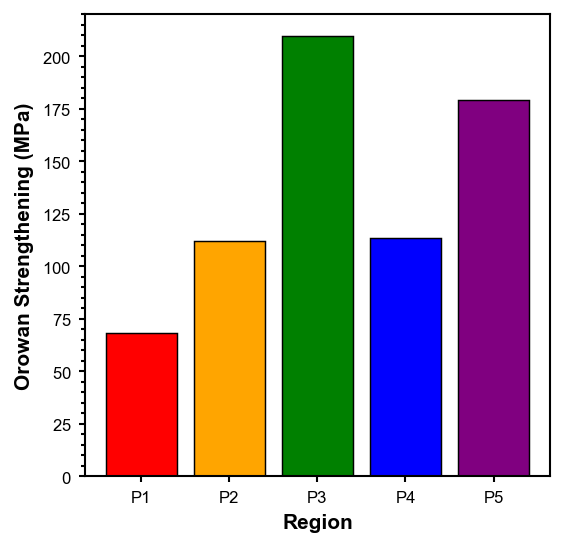

In [ ]:
# Plot

fig, ax = simple_plot_init([r'Region',r'Orowan Strengthening (MPa)'], figsize = [4,4], dpi=150)
colors = ['red', 'orange', 'green', 'blue', 'purple']

ax.bar(range(1, 6), results_df['Orowan_Stress'], tick_label=["P1", "P2", "P3", "P4", "P5"], color = colors, edgecolor='black', linewidth=0.7)

# edgecolor='black', linewidth=0.7, label = 'Non-aggl. NP')
#plt.ylim([9,11.55])

# ax.set_yscale('log')
plt.xticks(range(1, 6))  # Set major ticks at positions 1 to 5
plt.tick_params(axis='x', which='minor', length=0)  

#fig.savefig("fig_DED_NPT_inclusion_size.pdf", format="pdf", bbox_inches='tight')

print(OR)

## Orowan stress (DED): using numerically obatined values of d and L

In [7]:
# Load data
df = pd.read_csv('20241107_Orowan_data_DED_probes_L_d.csv')

# Apply orowan_stress function for each row in the DataFrame
# iterrows(): This iterates over each row in the DataFrame, providing access to each avg_intparticle_dist and avg_dispersoid_diameter
orowan_stresses = [ orowan_stress(row['avg_intparticle_dist'], row['avg_dispersoid_diameter']) for _, row in df.iterrows()]

# If needed, you can store the results in a DataFrame or dictionary for easy access
# You can optionally store the output in a DataFrame for easy reference
results_df = pd.DataFrame({
    'Probe': [f'P{i+1}_OR' for i in range(len(orowan_stresses))],
    'Orowan_Stress': orowan_stresses
})

print(results_df)

   Probe  Orowan_Stress
0  P1_OR      16.644827
1  P2_OR       9.845609
2  P3_OR    2839.151873
3  P4_OR       6.176141
4  P5_OR    1924.205773


In [ ]:
# Plot

fig, ax = simple_plot_init([r'Region',r'Orowan Strengthening (MPa)'], figsize = [4,4], dpi=150)
colors = ['red', 'orange', 'green', 'blue', 'purple']

ax.bar(range(1, 6), results_df['Orowan_Stress'], tick_label=["P1", "P2", "P3", "P4", "P5"], color = colors, edgecolor='black', linewidth=0.7)

# edgecolor='black', linewidth=0.7, label = 'Non-aggl. NP')
#plt.ylim([9,11.55])

# ax.set_yscale('log')
plt.xticks(range(1, 6))  # Set major ticks at positions 1 to 5
plt.tick_params(axis='x', which='minor', length=0)  

#fig.savefig("fig_DED_NPT_inclusion_size.pdf", format="pdf", bbox_inches='tight')

print(OR)

## Orowan stress (DED): using numerically obatined d and estimated L

In [8]:
df = pd.read_csv('20241107_Orowan_data_DED_probes_L_d.csv')
display(df)

,DED_Probes,avg_intparticle_dist,avg_dispersoid_diameter
0,P1,2130.371823,11.271199
1,P2,3601.153520,11.266468
2,P3,12.366442,10.876837
3,P4,5689.627422,10.909848
4,P5,18.244768,10.872936


   Probe  Orowan_Stress
0  P1_OR     354.822747
1  P2_OR     354.930512
2  P3_OR     364.063937
3  P4_OR     363.269743
4  P5_OR     364.158045


360.24899670653485

[99.93629392588544,
 99.89434368761331,
 96.43967384314531,
 96.73236668519576,
 96.40508586528217]

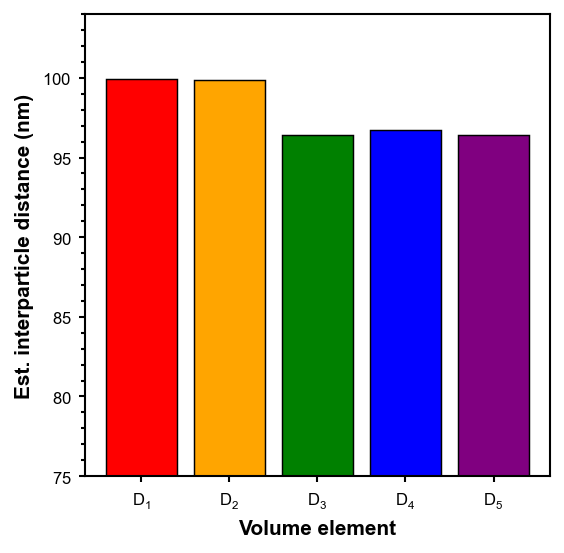

In [11]:
# Calculate volume_fraction of NP from weight fraction and densities of the NP and substance
wt_frac = 0.005 #0.5%
rho_np = 5850 # density of NP ZrO2
rho_ss = 7727 # Density of Fe20Cr
vol_frac = wt_frac*rho_ss/rho_np
# display(vol_frac)
"""
Calculate L based on the diameter values for a volume_fraction of NP
Use: interparticle_spacing(d_p, v_p)
"""
# Read avg inclusion diameter
df = pd.read_csv('20241107_Orowan_data_DED_probes_L_d.csv')

orowan_stresses = [ orowan_stress(interparticle_spacing(row['avg_dispersoid_diameter'], vol_frac), row['avg_dispersoid_diameter']) for _, row in df.iterrows()]


results_df = pd.DataFrame({
    'Probe': [f'P{i+1}_OR' for i in range(len(orowan_stresses))],
    'Orowan_Stress': orowan_stresses
})

print(results_df)
display(results_df['Orowan_Stress'].mean())
L_list = [interparticle_spacing(row['avg_dispersoid_diameter'], vol_frac) for _, row in df.iterrows()]
display(L_list)
# Plot

fig, ax = simple_plot_init([r'Volume element',r'Est. interparticle distance (nm)'], figsize = [4,4], dpi=150)
colors = ['red', 'orange', 'green', 'blue', 'purple']
tick_DED = ["$\mathregular{D_1}$", "$\mathregular{D_2}$", "$\mathregular{D_3}$", "$\mathregular{D_4}$", "$\mathregular{D_5}$"]
ax.bar(range(1, 6), L_list, tick_label=tick_DED, color = colors, edgecolor='black', linewidth=0.7)

# edgecolor='black', linewidth=0.7, label = 'Non-aggl. NP')
plt.ylim([75,104])

# ax.set_yscale('log')
plt.xticks(range(1, 6))  # Set major ticks at positions 1 to 5
plt.tick_params(axis='x', which='minor', length=0)  
fig.savefig("fig_DED_est_intpart_dist_VE.pdf", format="pdf", bbox_inches='tight')

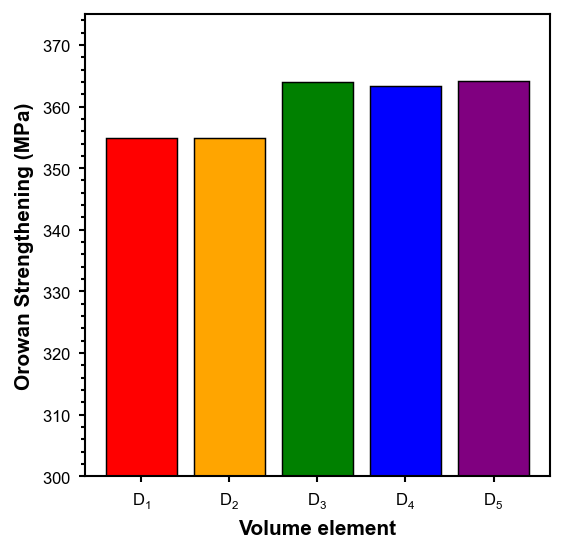

In [12]:
# Plot

fig, ax = simple_plot_init([r'Volume element',r'Orowan Strengthening (MPa)'], figsize = [4,4], dpi=150)
colors = ['red', 'orange', 'green', 'blue', 'purple']

ax.bar(range(1, 6), results_df['Orowan_Stress'], tick_label=tick_DED, color = colors, edgecolor='black', linewidth=0.7)

# edgecolor='black', linewidth=0.7, label = 'Non-aggl. NP')
#plt.ylim([9,11.55])

# ax.set_yscale('log')
plt.ylim([300,375])
plt.xticks(range(1, 6))  # Set major ticks at positions 1 to 5
plt.tick_params(axis='x', which='minor', length=0)  

fig.savefig("fig_DED_orowan_VE.pdf", format="pdf", bbox_inches='tight')

# print(OR)

## Orowan stress (PBF): using numerically obatined d and estimated L

[208.60901750537607,
 217.9638827961977,
 159.72535865538453,
 165.5121145306694,
 109.04093397227179]

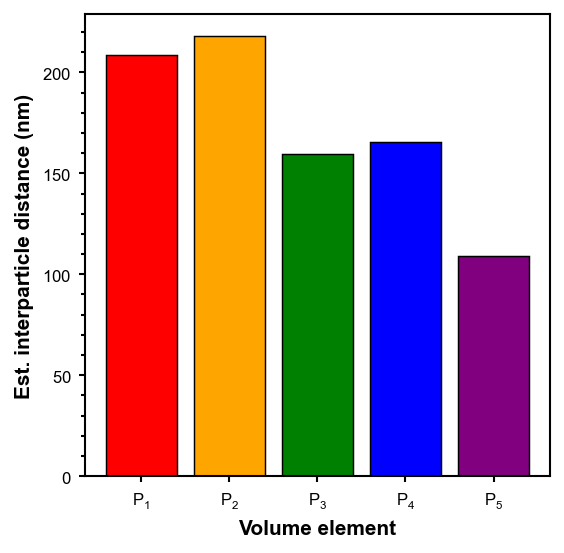

In [15]:
# Calculate volume_fraction of NP from weight fraction and densities of the NP and substance
wt_frac = 0.005 #0.5%
rho_np = 5850 # density of NP ZrO2
rho_ss = 7727 # Density of Fe20Cr
vol_frac = wt_frac*rho_ss/rho_np
# display(vol_frac)
"""
Calculate L based on the diameter values for a volume_fraction of NP
Use: interparticle_spacing(d_p, v_p)
"""
# Read avg inclusion diameter
df = pd.read_csv('Orowan_data_PBF_probes_L_d.csv')

orowan_stresses = [ orowan_stress(interparticle_spacing(row['avg_dispersoid_diameter'], vol_frac), row['avg_dispersoid_diameter']) for _, row in df.iterrows()]


results_df = pd.DataFrame({
    'Probe': [f'P{i+1}_OR' for i in range(len(orowan_stresses))],
    'Orowan_Stress': orowan_stresses
})

# print(results_df)
# display(results_df['Orowan_Stress'].mean())

# Plotting the estimated interparticle distance
L_list = [interparticle_spacing(row['avg_dispersoid_diameter'], vol_frac) for _, row in df.iterrows()]
display(L_list)
# Plot
tick_PBF = ["$\mathregular{P_1}$", "$\mathregular{P_2}$", "$\mathregular{P_3}$", "$\mathregular{P_4}$", "$\mathregular{P_5}$"]
fig, ax = simple_plot_init([r'Volume element',r'Est. interparticle distance (nm)'], figsize = [4,4], dpi=150)
colors = ['red', 'orange', 'green', 'blue', 'purple']

ax.bar(range(1, 6), L_list, tick_label=tick_PBF, color = colors, edgecolor='black', linewidth=0.7)

# edgecolor='black', linewidth=0.7, label = 'Non-aggl. NP')
#plt.ylim([9,11.55])

# ax.set_yscale('log')
plt.xticks(range(1, 6))  # Set major ticks at positions 1 to 5
plt.tick_params(axis='x', which='minor', length=0)  
fig.savefig("fig_PBF_est_intpart_dist_VE.pdf", format="pdf", bbox_inches='tight')

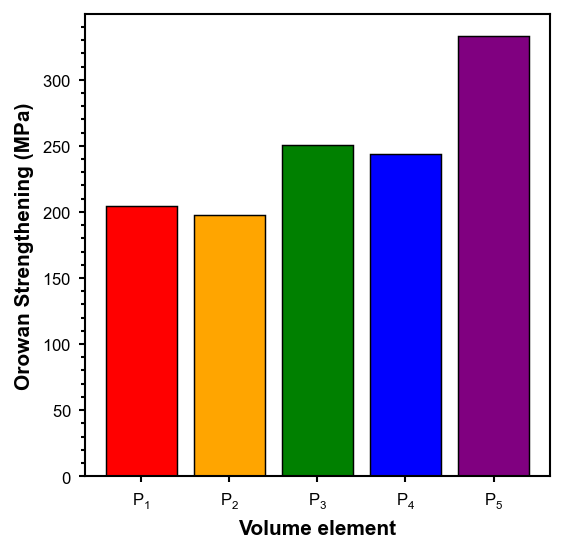

In [16]:
# Plot

fig, ax = simple_plot_init([r'Volume element',r'Orowan Strengthening (MPa)'], figsize = [4,4], dpi=150)
colors = ['red', 'orange', 'green', 'blue', 'purple']

ax.bar(range(1, 6), results_df['Orowan_Stress'], tick_label=tick_PBF, color = colors, edgecolor='black', linewidth=0.7)

# edgecolor='black', linewidth=0.7, label = 'Non-aggl. NP')
#plt.ylim([9,11.55])

# ax.set_yscale('log')
plt.xticks(range(1, 6))  # Set major ticks at positions 1 to 5
plt.tick_params(axis='x', which='minor', length=0)  

#fig.savefig("fig_DED_NPT_inclusion_size.pdf", format="pdf", bbox_inches='tight')
fig.savefig("fig_PBF_orowan_VE.pdf", format="pdf", bbox_inches='tight')

# print(OR)

In [15]:
# Data from Y.-K.Kim et al 2021 (https://doi.org/10.1016/j.compositesb.2021.108638)
M = 3.063
nu = 0.26
G = 80.85
b = 0.255
d_p = 25.8
v_p = 0.0228
L = interparticle_spacing(d_p, v_p)

sig_or = orowan_stress(M, nu, G, b, L, d_p)
display(sig_or)

0.3386510374755325

In [24]:
def interparticle_spacing(avg_diameter, vol_frac): 
    """
    To calculate the interparticle spacing (L) with the given: 
        1. Avg_diameter: average diameter of the particles (d_p)
        2. vol_frac: volume fraction of the particles (v_p)
    """
    L = np.sqrt(2/3) * avg_diameter * np.sqrt((np.pi/(4*vol_frac))-1)
    return L

def orowan_stress(M, nu, G, b, L, d_p):
    """
    To calculate Orowan stress using the following inputs:
        1. M : Taylor factor
        2. nu: Poisson's ratio
        3. G : Shear modulus
        4. b : Burgers vector
        5. L : interparticle spacing
        6. d_p: Avg particle diameter
    """
    sig_or = (0.4* M/(np.pi*np.sqrt(1-nu)))*(G*b/L)*np.log((np.sqrt(2/3)*d_p)/b)
    return sig_or

In [25]:
M = 3.063
nu = 0.26
G = 80.85
b = 0.255
d_p = 25.8
v_p = 0.0228
L = interparticle_spacing(d_p, v_p)

sig_or = orowan_stress(M, nu, G, b, L, d_p)
display(sig_or)

0.3386510374755325

## Orowan stress with varying avg particle diameter

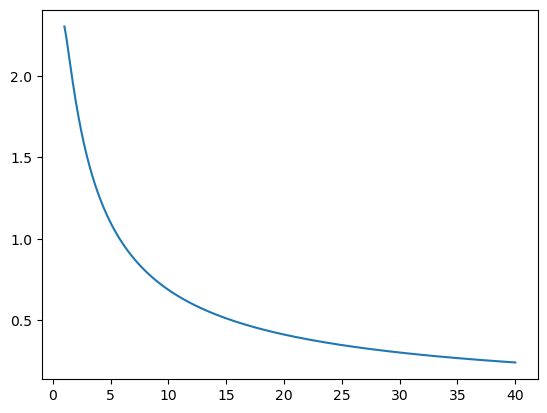

In [42]:
d_p = np.linspace(1,40,1000)
L = lambda d_p: interparticle_spacing(d_p, v_p)

sig_or = lambda d_p: orowan_stress(M, nu, G, b, L(d_p), d_p)

import matplotlib.pyplot as plt
plt.plot(d_p, sig_or(d_p))

In [75]:
# Find x values where y is closest to 1.0
indices = np.where(np.isclose(sig_or(d_p), 1.0))
x_values_at_y_1 = d_p[indices]

print(sig_or(5.77))

1.000466537174974
